In [30]:
import json
import pandas as pd
import os
from pandas.io.json import json_normalize

def read_jsonl(relative_path):
    with open(relative_path, "r") as file:
        lines = file.readlines()
    jsons = [json.loads(line) for line in lines]
    return pd.json_normalize(jsons)

def list_files_by_extension(extension, directory_path):
    files = [file for file in os.listdir(directory_path) if file.lower().endswith(extension.lower())]
    sorted_by_name = sorted(files)
    return sorted_by_name

def list_directores_in_path(relative_path):
    return [os.path.join(relative_path, fname) for fname in os.listdir(relative_path) if os.path.isdir(os.path.join(relative_path, fname))]

In [31]:
from functools import reduce
from itertools import chain
import numpy as np

def load_data_run(path):
    files = [os.path.join(path, file) for file in ["job_descriptions.jsonl", "sys_info.jsonl"]]
    meta = [read_jsonl(file) for file in files]
    events = read_jsonl(os.path.join(path, "metrics.jsonl"))
    meta = pd.merge(meta[0], meta[1], on="jobId")
    return np.array([meta, events])

def load_from_sources(paths):
    frames = np.array([load_data_run(path) for path in paths])
    return pd.concat(frames[:, 0]), pd.concat(frames[:, 1])

def load_frames_for_base(path, base):
    base_path = os.path.join(path,base)
    categories = list_directores_in_path(base_path)
    frames_paths =list(chain(*[list_directores_in_path(category) for category in categories]))
    return load_from_sources(frames_paths[:5])

In [32]:
data_root = "../data/parsed-logs/"

aws_bases = list_directores_in_path(data_root + "aws")
gcloud_bases = list_directores_in_path(data_root +"gcloud")

In [39]:
df = load_frames_for_base(data_root, "gcloud")

<ipython-input-31-557bf1839265>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([meta, events])


In [40]:
meta, events = df

In [48]:
filtered_events = events.loc[events["parameter"] != "event"].reset_index()
filtered_events

,index,time,workflowId,jobId,parameter,value,name,pid,value.read,value.write,...,value.rxCompressed,value.rxMulticast,value.txBytes,value.txPackets,value.txErrors,value.txDrop,value.txFifo,value.txColls,value.txCarrier,value.txCompressed
0,1,2020-06-01T12:22:39.136,WnJk6wsrA-1,WnJk6wsrA-1-7,io,NaN,dedup,18,65386.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2020-06-01T12:22:39.137,WnJk6wsrA-1,WnJk6wsrA-1-7,network,NaN,dedup,18,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,2020-06-01T12:22:39.158,WnJk6wsrA-1,WnJk6wsrA-1-7,io,NaN,dedup,20,370776.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,2020-06-01T12:22:39.158,WnJk6wsrA-1,WnJk6wsrA-1-7,network,NaN,dedup,20,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,2020-06-01T12:22:39.174,WnJk6wsrA-1,WnJk6wsrA-1-7,cpu,0,dedup,18,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300456,446,2020-06-01T08:03:21.804,3MURD6LD--1,3MURD6LD--1-35,io,NaN,mBackground,18,2249.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300457,447,2020-06-01T08:03:21.806,3MURD6LD--1,3MURD6LD--1-35,network,NaN,mBackground,18,NaN,NaN,...,0.0,0.0,1267.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
300458,449,2020-06-01T08:03:21.837,3MURD6LD--1,3MURD6LD--1-35,cpu,0,mBackground,18,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
300459,450,2020-06-01T08:03:21.837,3MURD6LD--1,3MURD6LD--1-35,memory,15060992,mBackground,18,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
filtered_events.parameter.unique()

array(['io', 'network', 'cpu', 'memory', 'ctime'], dtype=object)

In [92]:
events_grp = filtered_events.groupby(['jobId', 'parameter'])

In [93]:
aggregated = events_grp.agg({'value.read': 'sum', 'value.write': 'sum', 'value': 'sum'}).reset_index()

In [99]:
aggregated.loc[aggregated["parameter"] == "io"]

,jobId,parameter,value.read,value.write,value
0,14KATc5K2-1-1,io,6.302900e+04,1.0,0.0
4,14KATc5K2-1-10,io,1.770691e+07,1982.0,0.0
9,14KATc5K2-1-11,io,2.840050e+09,70286.0,0.0
14,14KATc5K2-1-12,io,1.688715e+09,46805.0,0.0
19,14KATc5K2-1-13,io,1.518565e+09,43244.0,0.0
...,...,...,...,...,...
3518,XY2iiSCeN-1-95,io,1.394980e+09,40775.0,0.0
3523,XY2iiSCeN-1-96,io,1.670183e+09,45778.0,0.0
3528,XY2iiSCeN-1-97,io,1.844493e+09,131093.0,0.0
3533,XY2iiSCeN-1-98,io,1.976663e+09,50903.0,0.0


{"read": 1225, "write": 1, "readSyscalls": 5, "writeSyscalls": 1, "readReal": 0, "writeReal": 0, "writeCancelled": 0}

In [154]:
io_params = ["read", "write", "readSyscalls", "writeSyscalls", "readReal", "writeReal", "writeCancelled"]
network_params = ["rxBytes", "rxPackets", "rxErrors", "rxDrop", "rxFifo", "rxFrame", "rxCompressed", "rxMulticast", "txBytes", "txPackets", "txErrors", "txDrop", "txFifo", "txColls", "txCarrier", "txCompressed"]

io_agg_kwargs={f"{param}_sum" : (f"value.{param}", "sum") for param in io_params}
network_agg_kwargs={f"{param}_sum" : (f"value.{param}", "sum") for param in network_params}
cpu_agg_kwargs={"cpu_mean": ('value', 'mean'), "cpu_max": ('value', 'max')}
memory_agg_kwargs={"memory_mean": ('value', 'mean'), "memory_max": ('value', 'max')}
ctime_agg_kwargs={"ctime_mean": ('value', 'mean'), "ctime_max": ('value', 'max'), "ctime_sum": ('value', 'sum')}

def extract_meta_from_metrics(frame):
    frame["value"] = pd.to_numeric(frame["value"])
    def postprocess(aggregated_frame, parameter_type):
        aggregated_frame = aggregated_frame.reset_index()
        return aggregated_frame.loc[aggregated_frame["parameter"] == parameter_type].drop("parameter", axis=1)
    
    frame_grp = frame.groupby(['jobId', 'parameter'])
    metrics = [
        postprocess(frame_grp.agg(**io_agg_kwargs), "io"),
        postprocess(frame_grp.agg(**network_agg_kwargs), "network"),          
        postprocess(frame_grp.agg(**cpu_agg_kwargs), "cpu"),
        postprocess(frame_grp.agg(**memory_agg_kwargs), "memory"),
        postprocess(frame_grp.agg(**ctime_agg_kwargs), "ctime")   
    ]   
    return reduce(lambda left, right: pd.merge(left,right,on='jobId'), metrics)

In [161]:
extract_meta_from_metrics(filtered_events)

,jobId,read_sum,write_sum,readSyscalls_sum,writeSyscalls_sum,readReal_sum,writeReal_sum,writeCancelled_sum,rxBytes_sum,rxPackets_sum,...,txColls_sum,txCarrier_sum,txCompressed_sum,cpu_mean,cpu_max,memory_mean,memory_max,ctime_mean,ctime_max,ctime_sum
0,14KATc5K2-1-10,1.770691e+07,1982.0,20969.0,39.0,7.680000e+06,69632.0,0.0,29784.0,90.0,...,0.0,0.0,0.0,43.034826,172.139303,7.084442e+07,2.576957e+08,875.000000,3480.0,3500.0
1,14KATc5K2-1-11,2.840050e+09,70286.0,622050.0,992.0,2.132771e+09,1794048.0,0.0,0.0,0.0,...,0.0,0.0,0.0,52.218133,185.500000,3.991752e+08,1.565585e+09,16074.827586,60630.0,932340.0
2,14KATc5K2-1-12,1.688715e+09,46805.0,412069.0,668.0,1.414955e+09,921600.0,0.0,304414.0,1024.0,...,0.0,0.0,0.0,52.340299,178.109453,3.677906e+08,1.438192e+09,11268.000000,41920.0,450720.0
3,14KATc5K2-1-13,1.518565e+09,43244.0,389519.0,598.0,1.068978e+09,876544.0,0.0,326630.0,1334.0,...,0.0,0.0,0.0,52.478987,176.000000,3.597253e+08,1.429369e+09,10755.263158,39930.0,408700.0
4,14KATc5K2-1-14,1.989252e+09,51215.0,455963.0,717.0,4.427776e+06,987136.0,0.0,337444.0,1180.0,...,0.0,0.0,0.0,52.310210,171.144279,4.055922e+08,1.520890e+09,12345.000000,46100.0,543180.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,XY2iiSCeN-1-95,1.394980e+09,40775.0,367698.0,565.0,0.000000e+00,823296.0,0.0,277832.0,1006.0,...,0.0,0.0,0.0,52.962341,171.641791,3.458579e+08,1.429873e+09,10340.000000,38180.0,372240.0
703,XY2iiSCeN-1-96,1.670183e+09,45778.0,411419.0,632.0,1.414955e+09,913408.0,0.0,0.0,0.0,...,0.0,0.0,0.0,52.428420,173.134328,3.788393e+08,1.433846e+09,11276.250000,41990.0,451050.0
704,XY2iiSCeN-1-97,1.844493e+09,131093.0,434648.0,29095.0,1.493545e+09,942080.0,0.0,325294.0,1216.0,...,0.0,0.0,0.0,53.323975,179.104478,4.040866e+08,1.509454e+09,12127.380952,44840.0,509350.0
705,XY2iiSCeN-1-98,1.976663e+09,50903.0,455869.0,700.0,1.572135e+09,987136.0,0.0,0.0,0.0,...,0.0,0.0,0.0,52.011420,173.500000,4.041373e+08,1.510924e+09,12213.181818,45810.0,537380.0


In [162]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

<AxesSubplot:ylabel='executable'>

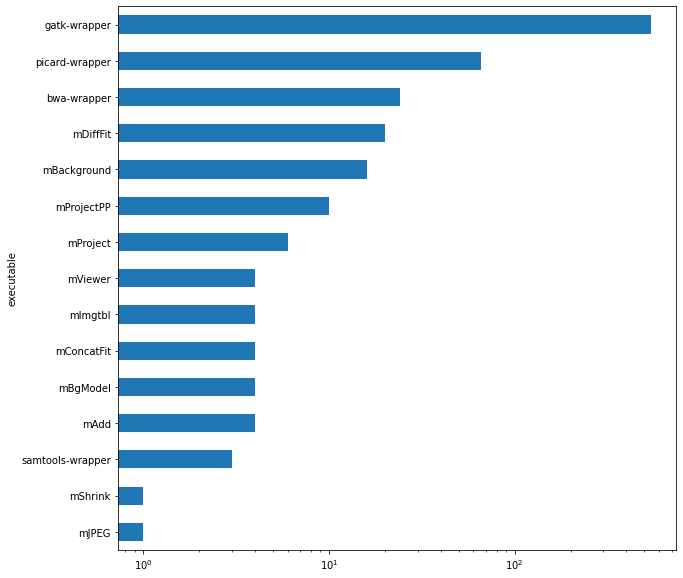

In [163]:
meta.groupby('executable').count().sort_values('size').plot.barh(y='size', logx=True, legend=False)

In [164]:
events.loc[events["jobId"] == "3MURD6LD--1-35"]

,time,workflowId,jobId,parameter,value,name,pid,value.read,value.write,value.readSyscalls,...,value.rxCompressed,value.rxMulticast,value.txBytes,value.txPackets,value.txErrors,value.txDrop,value.txFifo,value.txColls,value.txCarrier,value.txCompressed
445,2020-06-01T08:03:21.779,3MURD6LD--1,3MURD6LD--1-35,event,handlerStart,mBackground,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,2020-06-01T08:03:21.804,3MURD6LD--1,3MURD6LD--1-35,io,NaN,mBackground,18,2249.0,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
447,2020-06-01T08:03:21.806,3MURD6LD--1,3MURD6LD--1-35,network,NaN,mBackground,18,NaN,NaN,NaN,...,0.0,0.0,1267.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0
448,2020-06-01T08:03:21.813,3MURD6LD--1,3MURD6LD--1-35,event,jobStart,mBackground,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449,2020-06-01T08:03:21.837,3MURD6LD--1,3MURD6LD--1-35,cpu,0,mBackground,18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
450,2020-06-01T08:03:21.837,3MURD6LD--1,3MURD6LD--1-35,memory,15060992,mBackground,18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,2020-06-01T08:03:21.837,3MURD6LD--1,3MURD6LD--1-35,ctime,20,mBackground,18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
452,2020-06-01T08:03:21.891,3MURD6LD--1,3MURD6LD--1-35,event,jobEnd,mBackground,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,2020-06-01T08:03:21.893,3MURD6LD--1,3MURD6LD--1-35,event,handlerEnd,mBackground,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Todo - zmerge'ować base z metadanymi. Zrobić matrycę pearsona. Podstawowe klasyfikatory. GPT-2. Podział na 